# Comparison of slicing and gradient updates

For our project there are two primary places that we need to optimize, inserting a large number of small patches into a larger images and convolutions. This notebook is to demonstrate that just inserting the models using JAX is significantly more expensive than autograd (and directly doing the gradients with numpy) to the point where it is unusable for us.

In [1]:
from functools import partial

import numpy as np
import autograd.numpy as anp
import autograd
import jax.numpy as jnp
import jax

import matplotlib.pyplot as plt

## Direct gradients

We first illustrate the base case with direct gradients. Our actual models require FFTs and convolutions, but this represents the core of our algorithm that appears difficult to reproduce in JAX without significant performance issues

In [2]:
def get_component_model(sed, morph, center):
    """Get a model for a single component
    """
    y,x = center
    box = (slice(y-1, y+2), slice(x-1, x+2))
    return sed[:, None, None]*morph[None, :, :], box

def grad_get_component_model(chain_grad, model, sed, morph, center):
    """Calculate the gradient for a single component model
    """
    y,x = center
    box = (slice(y-1, y+2), slice(x-1, x+2))
    _chain_grad = chain_grad[:, box[0], box[1]]
    sed_grad = np.einsum("...jk,jk", _chain_grad, morph)
    morph_grad = np.einsum("i,i...", sed, _chain_grad)
    return sed_grad, morph_grad

def get_full_model(seds, morphs, centers, shape):
    """Combine all of the single component models into one model
    """
    model = np.zeros(shape)
    boxes = []
    for k in range(len(seds)):
        _model, box = get_component_model(seds[k], morphs[k], centers[k])
        model[:, box[0], box[1]] += _model
        boxes.append(box)
    return model, box

def grad_get_full_model(chain_grad, model, centers, seds, morphs):
    """Collect the gradients of all the single component models
    
    This would also multiply by dM/dM_i,
    except that all models have equal weights so `dM/dM_i=1`.
    """
    sed_grads = []
    morph_grads = []
    for k in range(len(centers)):
        grads = grad_get_component_model(chain_grad, model, seds[k], morphs[k], centers[k])
        sed_grads.append(grads[0])
        morph_grads.append(grads[1])
    return np.array(sed_grads), np.array(morph_grads)

def logL(data, model, weights=1):
    """Log-likelihood
    """
    return 0.5*weights*(data-model)**2

def grad_logL(data, model, weights=1):
    """Gradient of the log-likelihood
    """
    return weights*(model-data)

def calculate_gradients_direct(images, centers, seds, morphs):
    model, boxes = get_full_model(seds, morphs, centers, images.shape)
    gL = grad_logL(images, model)
    g_direct = grad_get_full_model(gL, model, centers, seds, morphs)
    return g_direct

## autograd gradients

We reuse `get_component_model` and `logL` but rewrite the other methods to build our models and take their gradients with autograd

In [135]:
@autograd.extend.primitive
def add_slice(destination, source, slices):
    destination[slices] += source
    return destination

def grad_add_slice_dest(result, destination, source, slices):
    return lambda grad_chain: grad_chain

def grad_add_slice_src(result, destination, source, slices):
    def result(grad_chain):
        return grad_chain[slices]
    return result

# Register this function in autograd
autograd.extend.defvjp(add_slice, grad_add_slice_dest, grad_add_slice_src)

def get_full_model_autograd(seds, morphs, centers, shape):
    model = anp.zeros(shape)
    boxes = []
    for k in range(len(seds)):
        _model, box = get_component_model(seds[k], morphs[k], centers[k])
        box = (slice(None),) + box
        model = add_slice(model, _model, box)
        boxes.append(box)
    return model, box

def loss_autograd(seds, morphs, image):
    """This is the method that autograd uses to calculate the gradients
    """
    model, boxes = get_full_model_autograd(seds, morphs, centers, image.shape)
    return anp.sum(logL(image, model))

def calculate_gradients_autograd(images, centers, seds, morphs):
    # Initialize the autograd loss function
    _grad = autograd.grad(partial(loss_autograd, image=images), tuple(range(2)))
    g_auto = _grad(seds, morphs)
    
    return g_auto

## JAX gradients

This code produces the same results while using JAX and `jit`.

In [152]:
def get_full_model_jax(seds, morphs, centers, shape):
    model = jnp.zeros(shape)
    boxes = []
    for k in range(len(seds)):
        _model, box = get_component_model(seds[k], morphs[k], centers[k])
        box = (slice(None),) + box
        model = jax.ops.index_add(model, jax.ops.index[box], _model)
        boxes.append(box)
    return model, box

def loss_jax(seds, morphs, image, centers):
    """This is the method that jax uses to calculate the gradients
    """
    model, boxes = get_full_model_jax(seds, morphs, centers, image.shape)
    return jnp.sum(logL(image, model))

def calculate_gradients_jax(images, centers, seds, morphs):
    _grad = jax.grad(partial(loss_jax, image=images, centers=centers), tuple(range(2)))
    g_jax = _grad(seds, morphs)
    
    return g_jax

# JIT gradients

This is the same code as in the JAX section, wrapped in jit

In [293]:
@jax.jit
def get_component_model_jit(sed, morph):
    """Get a model for a single component
    """
    shape = (sed.shape[0], morph.shape[0], morph.shape[1])
    _sed = jax.lax.broadcast_in_dim(sed, shape, (0,))
    _morph = jax.lax.broadcast_in_dim(morph, shape, (1,2))
    return _sed * _morph

def _update_model(model, k, seds, morphs, centers):
    y,x = centers[k]
    _model = get_component_model_jit(seds[k], morphs[k])
    start_indices = (0, y-1, x-1)
    _model += jax.lax.dynamic_slice(model, start_indices, _model.shape)
    model = jax.lax.dynamic_update_slice(model, _model, start_indices)
    return model, None

def get_full_model_jit(seds, morphs, centers, shape):
    model = jnp.zeros(shape)
    boxes = []
    func = partial(_update_model, seds=seds, morphs=morphs, centers=centers)
    model, _ = jax.lax.scan(func, model, np.arange(len(seds)))
    return model

def loss_jit(seds, morphs, image, centers):
    """This is the method that jax uses to calculate the gradients
    """
    model = get_full_model_jit(seds, morphs, centers, image.shape)
    return jnp.sum(logL(image, model))

def calculate_gradients_jit(images, centers, seds, morphs):
    _grad = jax.grad(partial(loss_jit, image=images, centers=centers), tuple(range(2)))
    g_jax = _grad(seds, morphs)
    
    return g_jax

## Build and Display the model

This builds the model and allows us to display it as an RGB image.

In [294]:
def img2rgb(image):
    """Display an image as an array
    """
    rgb = image.copy()
    rgb[rgb>255] = 255
    rgb[rgb<0] = 0
    rgb = rgb.astype(np.uint8)
    rgb = np.transpose(rgb, axes=(1,2,0))
    return rgb

def build_scene(shape, K, figsize=None, show=True):
    """Build an image and models for a collection of sources
    """
    B, N, M = shape
    images = np.zeros(shape)
    centers = np.zeros((K, 2), dtype=int)
    seds = np.zeros((K, B))
    morphs = np.zeros((K, 3, 3))
    morphs[:, 1, 1] = 1
    
    for k in range(K):
        morphs[k] = np.arange(9).reshape(3, 3)

    for k in range(K):
        cy = np.random.randint(4, images.shape[1]-4)
        cx = np.random.randint(4, images.shape[2]-4)
        center = np.array([cy, cx])
        sed = np.random.rand(B)
        sed *= 500/np.sum(sed)
        centers[k] = center
        y,x = center
        images[:, y-1:y+2, x-1:x+2] += morphs[k][None, :, :] * sed[:,None,None]
        seds[k] = sed
    if show:
        rgb = img2rgb(images)
        if figsize is not None:
            plt.figure(figsize=figsize)
        plt.imshow(rgb)
        plt.show()
    return images, centers, seds, morphs

## Test the models

We see that autograd is slower than direct gradients but in our experience the majority of the time is spent on convolutions and this minor difference in runtime isn't significant. However, the factor of greater than 100 slowdown with JAX is significant.

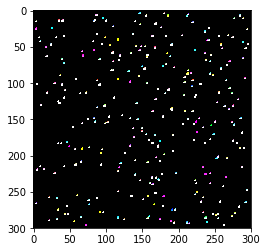

Direct gradients
CPU times: user 38.8 ms, sys: 185 µs, total: 39 ms
Wall time: 9.35 ms

autograd gradients
CPU times: user 293 ms, sys: 4.61 ms, total: 298 ms
Wall time: 74.8 ms
CPU times: user 5.43 s, sys: 852 ms, total: 6.28 s
Wall time: 4.55 s

JIT gradients
CPU times: user 477 ms, sys: 8.87 ms, total: 486 ms
Wall time: 470 ms


These should all be approximately (0, 0)
1.4551915228366852e-11 0.0
0.00390625 0.0625
0.00390625 0.0625


In [297]:
np.random.seed(1)

K = 300
shape = (3, 300, 300)
images, centers, seds, morphs = build_scene(shape, K)

# Convert the data into autograd arrays
images_autograd = anp.asarray(images)
centers_autograd = anp.asarray(centers)
seds_autograd = anp.asarray(seds)
morphs_autograd = anp.asarray(morphs)

# Convert the data into jax arrays
images_jax = jnp.asarray(images)
centers_jax = jnp.asarray(centers)
seds_jax = jnp.asarray(seds)
morphs_jax = jnp.asarray(morphs)

print("Direct gradients")
%time g_direct = calculate_gradients_direct(images, centers, seds/2, morphs)

print("\nautograd gradients")
%time g_auto = calculate_gradients_autograd(images_autograd, centers_autograd, seds_autograd/2, morphs_autograd)

#print("\nJAX gradients")
%time g_jax = calculate_gradients_jax(images_jax, centers_jax, seds_jax/2, morphs_jax)

print("\nJIT gradients")
%time g_jax = calculate_gradients_jit(images_jax, centers_jax, seds_jax/2, morphs_jax)

# Check that the results are the same
print("\n\nThese should all be approximately (0, 0)")
print(np.max(np.abs(g_auto[0]-g_direct[0])), np.max(np.abs(g_auto[1]-g_direct[1])))
print(np.max(np.abs(g_direct[0]-g_jax[0])), np.max(np.abs(g_direct[1]-g_jax[1])))
print(np.max(np.abs(g_direct[0]-g_jit[0])), np.max(np.abs(g_direct[1]-g_jit[1])))

## Isolating the issue

We further isolate the issue by executing just the `get_model` functions, which just inserts the `(3,3,3)` model into the full `(3, 300, 300)` image and note the significant difference in runtime.

In [296]:
%time m_direct = get_full_model(seds, morphs, centers, images.shape)[0]
%time m_autograd = get_full_model_autograd(seds_autograd, morphs_autograd, centers_autograd, images.shape)[0]
%time m_jax = get_full_model_jax(seds_jax, morphs_jax, centers_jax, images.shape)[0]
%time m_jit = get_full_model_jit(seds_jax, morphs_jax, centers_jax, images.shape)

print("\n\nThese should all be approximately (0, 0)")
print(np.max(m_direct-m_autograd))
print(np.max(m_direct-m_jax))
print(np.max(m_direct-m_jit))

CPU times: user 4.63 ms, sys: 1.21 ms, total: 5.84 ms
Wall time: 5.37 ms
CPU times: user 5.04 ms, sys: 570 µs, total: 5.61 ms
Wall time: 5.04 ms
CPU times: user 3.44 s, sys: 683 ms, total: 4.13 s
Wall time: 3.11 s
CPU times: user 128 ms, sys: 31.2 ms, total: 159 ms
Wall time: 157 ms


These should all be approximately (0, 0)
0.0
0.00024414062
0.00024414062
